# Platform Engagement and Growth Analytics

## Data Setup

In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

con=duckdb.connect()

con.execute("""
CREATE TABLE users_raw AS SELECT * FROM read_csv_auto('data/users.csv');
CREATE TABLE sessions_raw AS SELECT * FROM read_csv_auto('data/sessions.csv');
CREATE TABLE content_raw AS SELECT * FROM read_csv_auto('data/content.csv');
""")

In [3]:
print("\nSample data from each table:")
print("================================")
print("Users Table:")
print(f"\n{con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf()}")
print("================================")
print("Sessions Table:")
print(f"\n{con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf()}")


Sample data from each table:
Users Table:

  user_id signup_date cancel_date       region plan_type  price_usd  \
0  U00001  2024-05-11         NaT         APAC     BASIC       8.99   
1  U00002  2023-03-28         NaT        LATAM     Basic      10.99   
2  U00003  2023-01-20  2024-05-19  Europe/MENA  Standard      14.99   
3  U00004  2024-07-29         NaT        LatAm  Standard      14.99   
4  U00005  2023-08-02         NaT        LATAM  Standard      13.99   

  acquisition_channel  
0            referral  
1             Organic  
2             organic  
3            Referral  
4            referral  
Sessions Table:

  session_id user_id       date   device  duration_min content_type  \
0   S0000001  U01743 2024-04-22   Tablet         29.65        Movie   
1   S0000002  U01804 2023-01-05   Tablet          8.84       Series   
2   S0000003  U01712 2024-12-04   Tablet          0.00       Shorts   
3   S0000004  U01204 2023-03-03  Desktop         47.17       Shorts   
4   S0000005 

## Data Cleaning

### User Table

#### Checking for issues

In [4]:
print(con.execute("SELECT * FROM users_raw").fetchdf().info())
print(con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf())

print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_raw GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_raw GROUP BY plan_type").fetchdf())

print("price_usd values:")
print(con.execute("SELECT price_usd, COUNT(price_usd) FROM users_raw GROUP BY price_usd").fetchdf())

print("Acquisition channel values:")
print(con.execute("SELECT acquisition_channel, COUNT(acquisition_channel) FROM users_raw GROUP BY acquisition_channel").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(price_usd IS NULL) AS null_price,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(acquisition_channel IS NULL) AS null_acquisition_channel,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_raw;
""").fetchdf())

print("Cancel date before signup date:")
print(con.execute("""
SELECT *
FROM users_raw
WHERE cancel_date < signup_date;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              2060 non-null   object        
 1   signup_date          2060 non-null   datetime64[us]
 2   cancel_date          586 non-null    datetime64[us]
 3   region               1992 non-null   object        
 4   plan_type            2015 non-null   object        
 5   price_usd            2037 non-null   float64       
 6   acquisition_channel  2060 non-null   object        
dtypes: datetime64[us](2), float64(1), object(4)
memory usage: 112.8+ KB
None
  user_id signup_date cancel_date       region plan_type  price_usd  \
0  U00001  2024-05-11         NaT         APAC     BASIC       8.99   
1  U00002  2023-03-28         NaT        LATAM     Basic      10.99   
2  U00003  2023-01-20  2024-05-19  Europe/MENA  Standard      14.99   
3  U00004  2024-07-

#### Clean and validate, export to pandas dataframe

In [5]:
con.execute("""
CREATE OR REPLACE TABLE users_clean AS
WITH ranked AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY signup_date DESC, cancel_date NULLS LAST) AS rn
  FROM users_raw
)
SELECT
  user_id,
  CAST(signup_date AS DATE) AS signup_date,
  CASE 
    WHEN TRY_CAST(cancel_date AS DATE) IS NULL THEN NULL
    WHEN TRY_CAST(cancel_date AS DATE) < TRY_CAST(signup_date AS DATE) THEN NULL  -- fix bad ordering
    ELSE CAST(cancel_date AS DATE)
  END AS cancel_date,
  CASE
    WHEN LOWER(region) IN ('na','n. america','north america') THEN 'North America'
    WHEN LOWER(region) LIKE '%lat%' THEN 'LATAM'
    WHEN LOWER(region) LIKE '%emea%' OR LOWER(region) LIKE '%europe%' THEN 'EMEA'
    WHEN LOWER(region) LIKE '%apac%' OR LOWER(region) LIKE '%asia%' THEN 'APAC'
    ELSE COALESCE(NULLIF(TRIM(region),''), 'Unknown')
  END AS region,
  CASE
    WHEN LOWER(plan_type) LIKE '%b%' THEN 'Basic'
    WHEN LOWER(plan_type) LIKE '%st%' THEN 'Standard'
    WHEN LOWER(plan_type) LIKE '%an%' THEN 'Standard'
    WHEN LOWER(plan_type) LIKE 'p%' THEN 'Premium'
    ELSE COALESCE(NULLIF(TRIM(plan_type),''), 'Unknown')
  END AS plan_type,
  TRY_CAST(price_usd AS DOUBLE) AS price_usd,
  CASE
    WHEN LOWER(acquisition_channel) LIKE '%ic%' THEN 'Organic'
    WHEN LOWER(acquisition_channel) LIKE '%or%' THEN 'Organic'
    WHEN LOWER(acquisition_channel) LIKE '%soc%' THEN 'Paid Social'
    WHEN LOWER(acquisition_channel) LIKE '%ia%' THEN 'Paid Social'
    WHEN LOWER(acquisition_channel) LIKE '%ref%' THEN 'Referral'
    WHEN LOWER(acquisition_channel) LIKE '%err%' THEN 'Referral'
    WHEN LOWER(acquisition_channel) LIKE '%ch%' THEN 'Paid Search'
    WHEN LOWER(acquisition_channel) LIKE '%par%' THEN 'Partnership'
    WHEN LOWER(acquisition_channel) LIKE '%ner%' THEN 'Partnership'
    ELSE acquisition_channel
  END AS acquisition_channel
FROM ranked
WHERE rn = 1 AND price_usd IS NOT NULL
  AND user_id IS NOT NULL
;
""")

print(con.execute("DESCRIBE users_clean").fetchdf())

print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_clean GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_clean GROUP BY plan_type").fetchdf())

print("price_usd values:")
print(con.execute("SELECT price_usd, COUNT(price_usd) FROM users_clean GROUP BY price_usd").fetchdf())

print("Acquisition channel values:")
print(con.execute("SELECT acquisition_channel, COUNT(acquisition_channel) FROM users_clean GROUP BY acquisition_channel").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(price_usd IS NULL) AS null_price,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(acquisition_channel IS NULL) AS null_acquisition_channel,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_clean;
""").fetchdf())

print("Cancel date before signup date:")
print(con.execute("""
SELECT *
FROM users_clean
WHERE cancel_date < signup_date;
""").fetchdf())

users = con.execute("""SELECT * FROM users_clean""").fetch_df()

           column_name column_type null   key default extra
0              user_id     VARCHAR  YES  None    None  None
1          signup_date        DATE  YES  None    None  None
2          cancel_date        DATE  YES  None    None  None
3               region     VARCHAR  YES  None    None  None
4            plan_type     VARCHAR  YES  None    None  None
5            price_usd      DOUBLE  YES  None    None  None
6  acquisition_channel     VARCHAR  YES  None    None  None
region values:
          region  count(region)
0           EMEA            485
1          LATAM            494
2        Unknown             63
3  North America            458
4           APAC            478
plan_type values:
  plan_type  count(plan_type)
0  Standard               688
1   Premium               627
2     Basic               620
3   Unknown                43
price_usd values:
   price_usd  count(price_usd)
0      16.99               127
1      13.99               409
2      11.99                35
3  

#### Looking for outliers

  user_id signup_date cancel_date         region plan_type  price_usd  \
0  U00053  2024-10-20         NaT  North America   Premium      16.99   
1  U00054  2023-09-25         NaT           EMEA     Basic       9.99   
2  U00071  2024-03-24         NaT          LATAM   Unknown       9.99   
3  U00072  2023-05-30  2023-07-13           APAC     Basic       9.99   
4  U00076  2024-05-28         NaT  North America  Standard      13.99   

  acquisition_channel  
0         Paid Social  
1            Referral  
2         Partnership  
3         Partnership  
4             Organic  


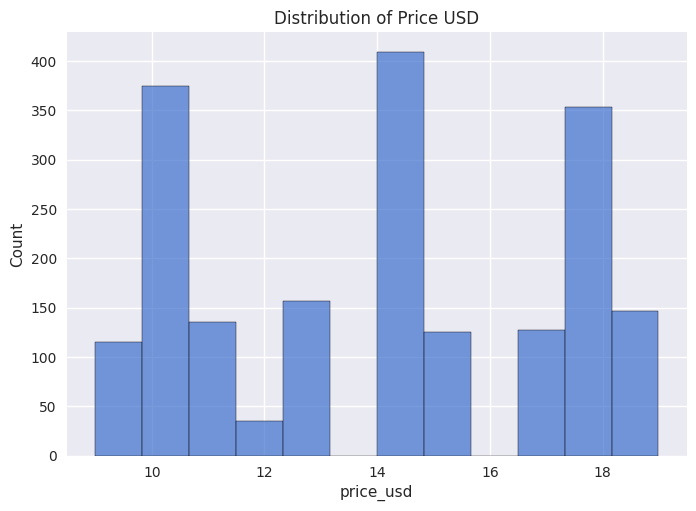

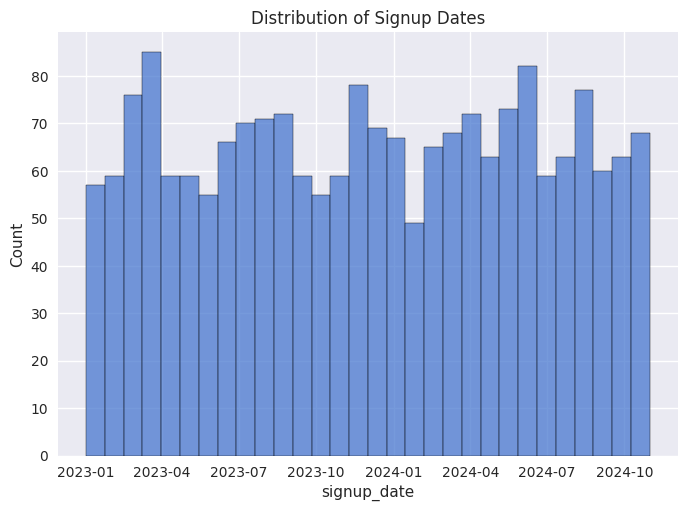

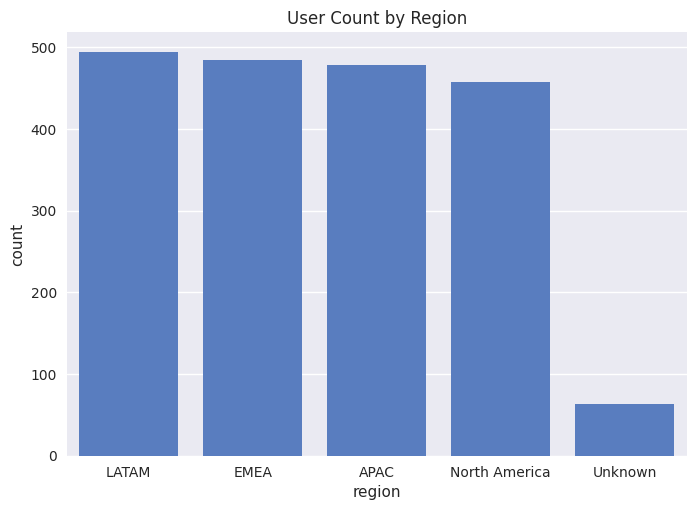

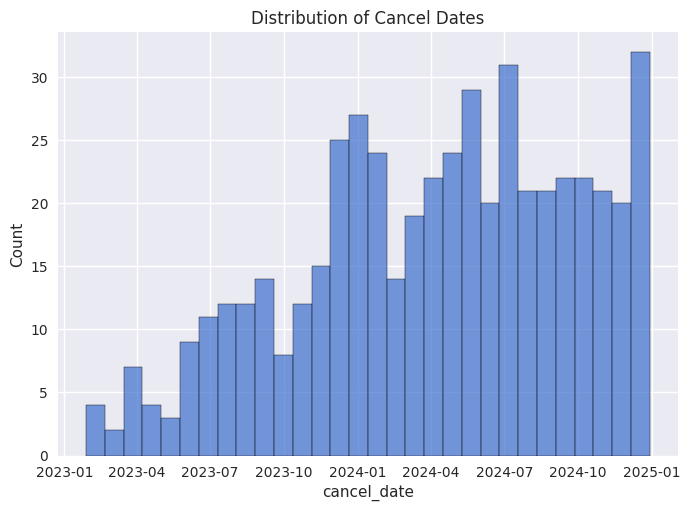

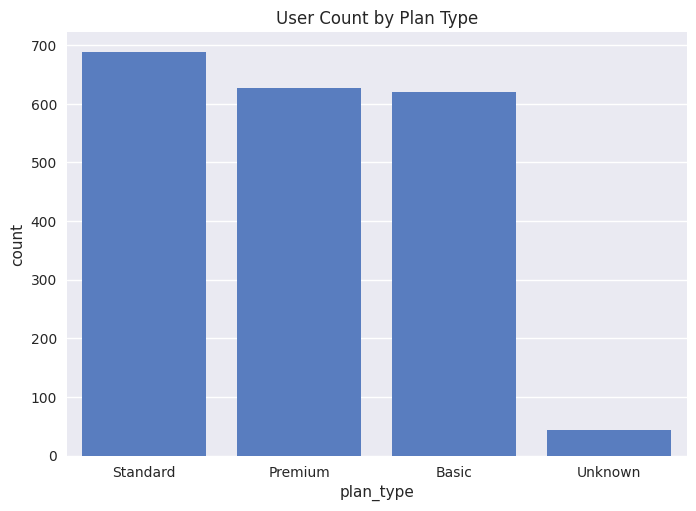

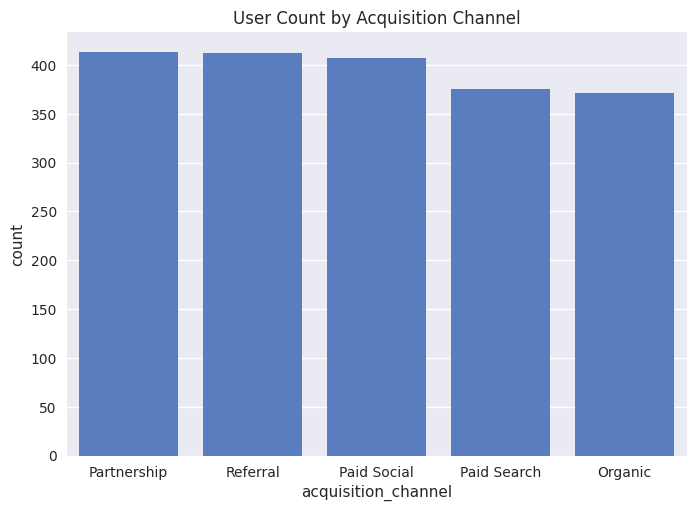

In [6]:
print(users.head())

sns.histplot(users, x='price_usd')
plt.title('Distribution of Price USD')
plt.show()

sns.histplot(users, x='signup_date', bins=30)
plt.title('Distribution of Signup Dates')
plt.show()

sns.countplot(data=users, x='region', order=users['region'].value_counts().index)
plt.title('User Count by Region')
plt.show()

sns.histplot(users, x='cancel_date', bins=30)
plt.title('Distribution of Cancel Dates')
plt.show()

sns.countplot(data=users, x='plan_type', order=users['plan_type'].value_counts().index)
plt.title('User Count by Plan Type')
plt.show()

sns.countplot(data=users, x='acquisition_channel', order=users['acquisition_channel'].value_counts().index)
plt.title('User Count by Acquisition Channel')
plt.show()

### Sessions Table

#### Description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session_id            51000 non-null  object        
 1   user_id               51000 non-null  object        
 2   date                  51000 non-null  datetime64[us]
 3   device                50457 non-null  object        
 4   duration_min          50491 non-null  float64       
 5   content_type          51000 non-null  object        
 6   content_id            51000 non-null  object        
 7   watch_completion_pct  50506 non-null  float64       
dtypes: datetime64[us](1), float64(2), object(5)
memory usage: 3.1+ MB
None

Sample values:
  session_id user_id       date   device  duration_min content_type  \
0   S0000001  U01743 2024-04-22   Tablet         29.65        Movie   
1   S0000002  U01804 2023-01-05   Tablet          8.84       Series   
2   S00

/tmp/ipykernel_1812/2351889488.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zero_sessions_over_time = sessions_0_min_duration.groupby(pd.Grouper(key='date', freq='M')).size().reset_index(name='count')


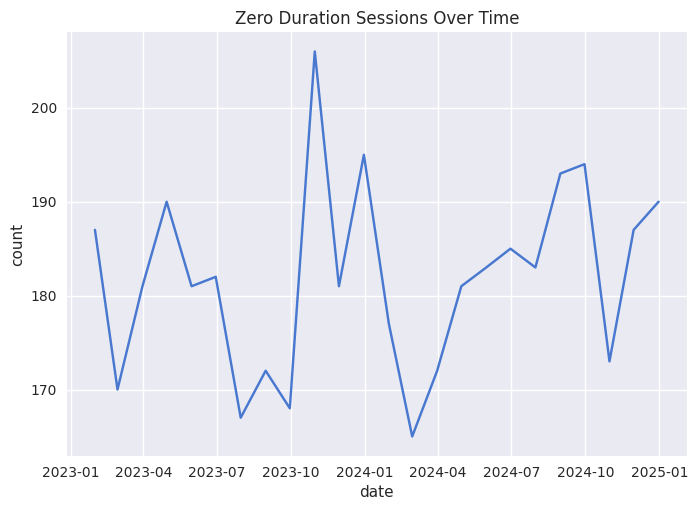

In [7]:
print(con.execute("SELECT * FROM sessions_raw").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration_min, watch_completion_pct FROM sessions_raw").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_raw;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_raw GROUP BY device").fetchdf())

print("\nContent Type values:")
print(con.execute("SELECT content_type, COUNT(content_type) from sessions_raw GROUP BY content_type").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration_min IS NULL) AS null_duration_min,
       COUNTIF(watch_completion_pct IS NULL) AS null_watch_completion_pct,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(content_type IS NULL) AS null_content_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date
FROM sessions_raw;
""").fetchdf())

sessions_0_min_duration = con.execute("""
SELECT * FROM sessions_raw WHERE duration_min = 0
""").fetch_df()

zero_sessions_over_time = sessions_0_min_duration.groupby(pd.Grouper(key='date', freq='M')).size().reset_index(name='count')
sns.lineplot(data=zero_sessions_over_time, x='date', y='count')
plt.title('Zero Duration Sessions Over Time')
plt.show()

#### Standardize Columns

In [8]:
con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
  SELECT
    session_id,
    CAST(date AS DATE) AS date,
    CASE 
      WHEN TRY_CAST(duration_min AS DOUBLE) IS NULL OR TRY_CAST(duration_min AS DOUBLE) < 0 THEN NULL
      ELSE TRY_CAST(duration_min AS DOUBLE)
    END AS duration_min,
    CASE 
      WHEN TRY_CAST(watch_completion_pct AS DOUBLE) IS NULL OR TRY_CAST(watch_completion_pct AS DOUBLE) < 0 OR TRY_CAST(watch_completion_pct AS DOUBLE) > 100 THEN NULL
      ELSE TRY_CAST(watch_completion_pct AS DOUBLE)
    END AS watch_completion_pct,
    CASE
      WHEN LOWER(device) LIKE '%mo%' THEN 'Mobile'
      WHEN LOWER(device) LIKE '%bil%' THEN 'Mobile'
      WHEN LOWER(device) LIKE '%tab%' THEN 'Tablet'
      WHEN LOWER(device) LIKE '%let%' THEN 'Tablet'
      WHEN LOWER(device) LIKE '%desk%' THEN 'Desktop'
      WHEN LOWER(device) LIKE '%top%' THEN 'Desktop'
      WHEN LOWER(device) LIKE '%tv%' THEN 'TV'
      ELSE device
    END AS device,
    CASE
      WHEN LOWER(content_type) LIKE '%vid%' THEN 'Video'
      WHEN LOWER(content_type) LIKE '%art%' THEN 'Article'
      WHEN LOWER(content_type) LIKE '%pod%' THEN 'Podcast'
      ELSE content_type
    END AS content_type,
    user_id,
    content_id
  FROM sessions_raw
  WHERE session_id IS NOT NULL AND duration_min < 300 AND duration_min > 0
""")

print(con.execute("SELECT * FROM sessions_clean").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_clean LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration_min, watch_completion_pct FROM sessions_clean").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_clean GROUP BY device").fetchdf())

print("\nContent Type values:")
print(con.execute("SELECT content_type, COUNT(content_type) from sessions_clean GROUP BY content_type").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration_min IS NULL) AS null_duration_min,
       COUNTIF(watch_completion_pct IS NULL) AS null_watch_completion_pct,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(content_type IS NULL) AS null_content_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date
FROM sessions_clean;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45425 entries, 0 to 45424
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session_id            45425 non-null  object        
 1   date                  45425 non-null  datetime64[us]
 2   duration_min          45425 non-null  float64       
 3   watch_completion_pct  40584 non-null  float64       
 4   device                44931 non-null  object        
 5   content_type          45425 non-null  object        
 6   user_id               45425 non-null  object        
 7   content_id            45425 non-null  object        
dtypes: datetime64[us](1), float64(2), object(5)
memory usage: 2.8+ MB
None

Sample values:
  session_id       date  duration_min  watch_completion_pct   device  \
0   S0000001 2024-04-22         29.65                  37.6   Tablet   
1   S0000002 2023-01-05          8.84                  75.0   Tablet   
2   

#### Dedup

In [9]:
con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
WITH ranked AS (
SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY user_id, date, duration_min, watch_completion_pct, device, content_type NULLS LAST) AS rn
FROM sessions_clean
)
SELECT
    session_id,
    date,
    duration_min,
    watch_completion_pct,
    device,
    content_type,
    user_id,
    content_id
FROM ranked
WHERE rn = 1 AND duration_min IS NOT NULL
""")

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nRemaining Duplicate Rows:")
print(con.execute("""
WITH duplicate_sessions AS (
SELECT session_id
FROM sessions_clean
GROUP BY session_id
HAVING COUNT(*) > 1
)
SELECT
                  date,
                  duration_min,
                  watch_completion_pct,
                  device,
                  content_type,
                  content_id
FROM sessions_clean
WHERE session_id IN (SELECT session_id FROM duplicate_sessions)
ORDER BY session_id, user_id, date, duration_min, watch_completion_pct, device, content_type, content_id NULLS LAST
""").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration_min IS NULL) AS null_duration_min,
       COUNTIF(watch_completion_pct IS NULL) AS null_watch_completion_pct,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(content_type IS NULL) AS null_content_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date,
       COUNTIF(content_id IS NULL) AS null_content_id
FROM sessions_clean;
""").fetchdf())
print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration_min, watch_completion_pct FROM sessions_clean").fetchdf().describe())
print("\nSample values:")
print(con.execute("SELECT * FROM sessions_clean").fetch_df().head())


Session ID Distinct Count:
   distinct_session_ids  total_session_ids
0                 44547              44547

Remaining Duplicate Rows:
Empty DataFrame
Columns: [date, duration_min, watch_completion_pct, device, content_type, content_id]
Index: []

Null Values:
   total_rows  null_duration_min  null_watch_completion_pct  null_device  \
0       44547                0.0                     4730.0        470.0   

   null_content_type  null_user_id  null_date  null_content_id  
0                0.0           0.0        0.0              0.0  

Session Quantitative Data Statistics:
                             date  duration_min  watch_completion_pct
count                       44547  44547.000000          39817.000000
mean   2023-12-30 11:46:45.764697     39.160755             61.398099
min           2023-01-01 00:00:00      0.010000              0.000000
25%           2023-06-30 00:00:00     22.630000             47.000000
50%           2023-12-31 00:00:00     37.690000             6

Export to Dataframe

In [10]:
sessions = con.execute("""SELECT * FROM sessions_clean""").fetch_df()
sessions.head()

,session_id,date,duration_min,watch_completion_pct,device,content_type,user_id,content_id
0,S0036147,2023-02-02,54.81,1.3,Tablet,Movie,U01854,C0098
1,S0036173,2024-04-14,45.36,27.4,Mobile,Movie,U00382,C0150
2,S0036261,2023-06-28,97.77,76.3,Mobile,Movie,U01785,C0119
3,S0036301,2024-06-12,10.33,71.2,TV,Movie,U01740,C0217
4,S0036323,2024-03-23,1.64,2.9,TV,Movie,U00566,C0139


#### Finding Outliers

  session_id       date  duration_min  watch_completion_pct  device  \
0   S0036147 2023-02-02         54.81                   1.3  Tablet   
1   S0036173 2024-04-14         45.36                  27.4  Mobile   
2   S0036261 2023-06-28         97.77                  76.3  Mobile   
3   S0036301 2024-06-12         10.33                  71.2      TV   
4   S0036323 2024-03-23          1.64                   2.9      TV   

  content_type user_id content_id  
0        Movie  U01854      C0098  
1        Movie  U00382      C0150  
2        Movie  U01785      C0119  
3        Movie  U01740      C0217  
4        Movie  U00566      C0139  


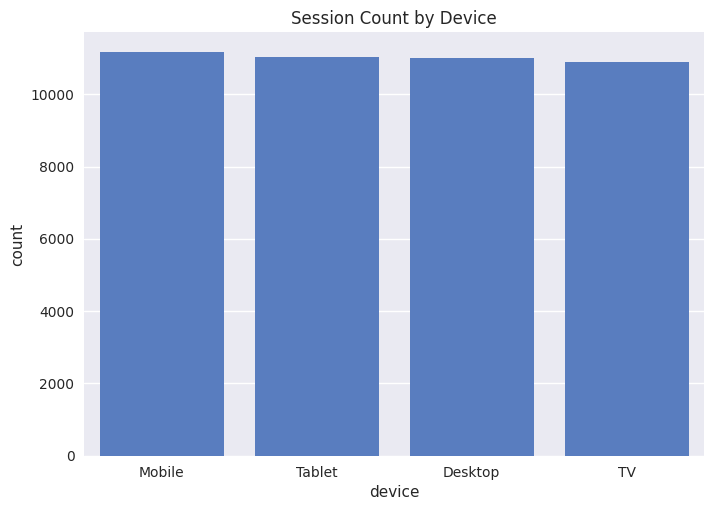

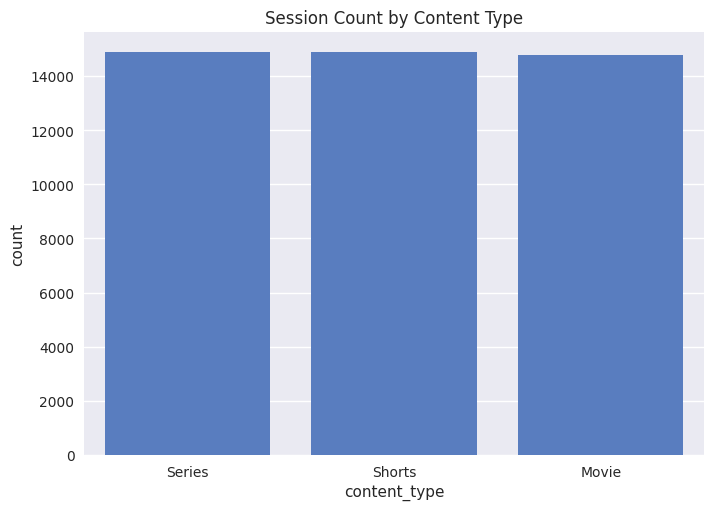

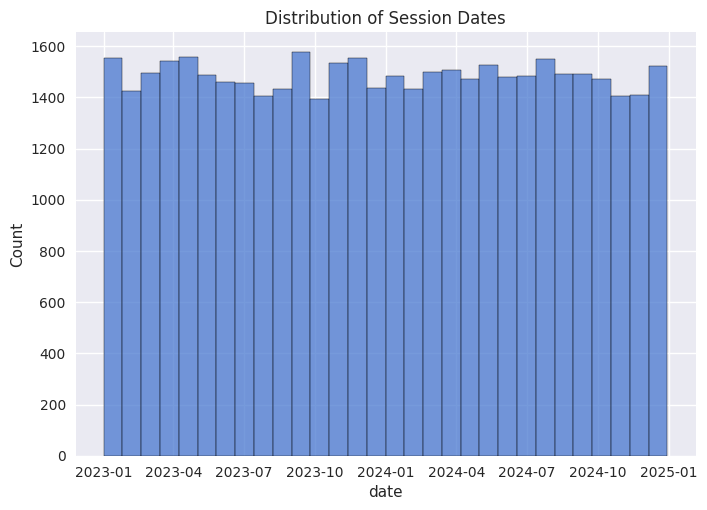

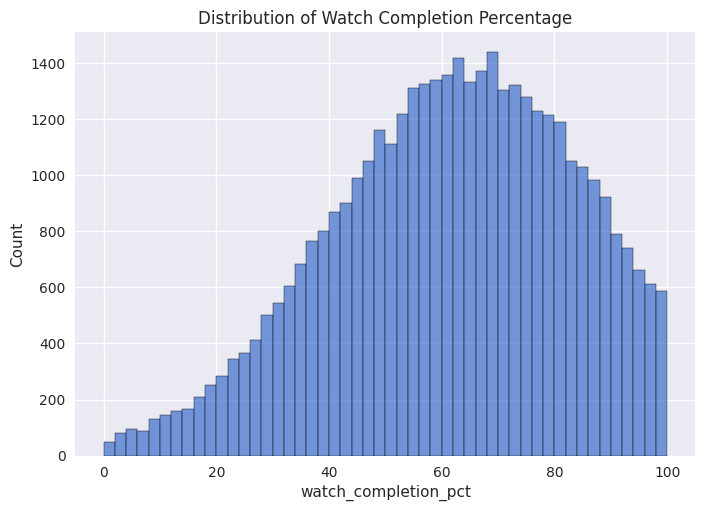

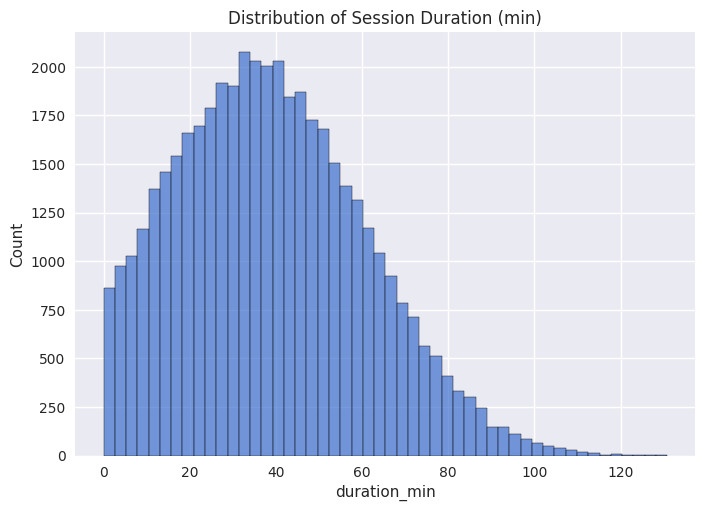

In [11]:
print(sessions.head())

sns.countplot(data=sessions, x='device', order=sessions['device'].value_counts().index)
plt.title('Session Count by Device')
plt.show()

sns.countplot(data=sessions, x='content_type', order=sessions['content_type'].value_counts().index)
plt.title('Session Count by Content Type')
plt.show()

sns.histplot(sessions, x='date', bins=30)
plt.title('Distribution of Session Dates')
plt.show()

sns.histplot(sessions, x='watch_completion_pct', bins=50)
plt.title('Distribution of Watch Completion Percentage')
plt.show()

sns.histplot(sessions, x='duration_min', bins=50)
plt.title('Distribution of Session Duration (min)')
plt.show()

### Content Table

#### Description


Sample values:
  content_id       title        genre  runtime_min release_date  \
0      C0001  Title 0001       Action           56   2022-04-17   
1      C0002  Title 0002  Documentary           23   2023-12-30   
2      C0003  Title 0003    Animation           66   2023-11-18   
3      C0004  Title 0004  DOCUMENTARY           10   2024-09-07   
4      C0005  Title 0005       SCI-FI           58   2023-04-16   

   licensed_flag  production_cost_usd  
0              1           2380854.17  
1              1           3879005.72  
2              1           6644921.72  
3              1           1557474.86  
4              0           3081540.95  

Content Raw Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   content_id           224 non-null    object        
 1   title                224 non-null   

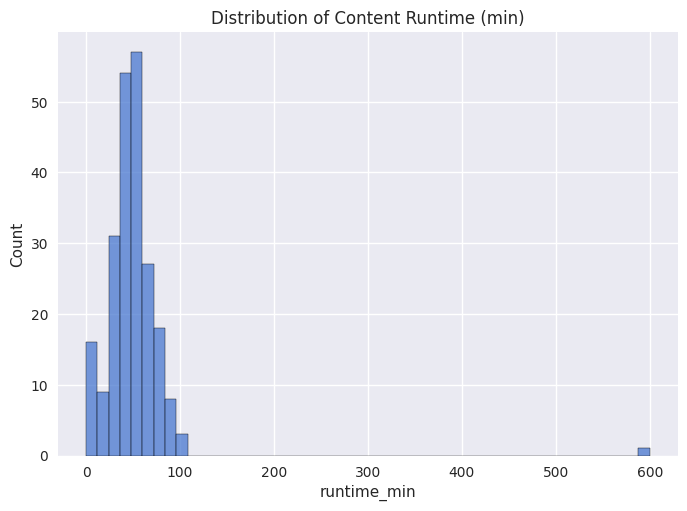

In [12]:
print("\nSample values:")
print(con.execute(""" SELECT * FROM content_raw LIMIT 5; """).fetch_df())

print("\nContent Raw Table Info:")
print(con.execute("""SELECT * FROM content_raw""").fetch_df().info())

print ("\nGenre values:")
print(con.execute("SELECT genre, COUNT(genre) from content_raw GROUP BY genre").fetchdf())

print("\nDescriptive Statistics for Quantitative Columns:")
print(con.execute("SELECT runtime_min, release_date FROM content_raw").fetchdf().describe())

print("\nDuplicate Count:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT content_id) AS distinct_content_ids
FROM content_raw;
""").fetchdf())

sns.histplot(con.execute("SELECT runtime_min FROM content_raw").fetch_df(), x='runtime_min', bins=50)
plt.title('Distribution of Content Runtime (min)')
plt.show()

#### Standardize Columns & Dedup

In [13]:
con.execute("""
CREATE OR REPLACE TABLE content_clean AS
  WITH ranked AS (
  SELECT
      *,
      ROW_NUMBER() OVER (PARTITION BY content_id ORDER BY genre, runtime_min, release_date NULLS LAST) AS rn
  FROM content_raw
  )
  SELECT
    content_id,
    CASE
      WHEN LOWER(genre) LIKE '%dr%' THEN 'Drama'
      WHEN LOWER(genre) LIKE '%com%' THEN 'Comedy'
      WHEN LOWER(genre) LIKE '%med%' THEN 'Comedy'
      WHEN LOWER(genre) LIKE '%act%' THEN 'Action'
      WHEN LOWER(genre) LIKE '%ion%' THEN 'Action'
      WHEN LOWER(genre) LIKE '%thr%' THEN 'Thriller'
      WHEN LOWER(genre) LIKE '%ill%' THEN 'Thriller'
      WHEN LOWER(genre) LIKE '%doc%' THEN 'Documentary'
      WHEN LOWER(genre) LIKE '%ary%' THEN 'Documentary'
      WHEN LOWER(genre) LIKE '%hor%' THEN 'Horror'
      WHEN LOWER(genre) LIKE '%ror%' THEN 'Horror'
      WHEN LOWER(genre) LIKE '%rea%' THEN 'Reality'
      WHEN LOWER(genre) LIKE '%lit%' THEN 'Reality'
      WHEN LOWER(genre) LIKE '%sci%' THEN 'Sci-Fi'
      ELSE COALESCE(NULLIF(TRIM(genre),''), 'Unknown')
    END AS genre,
    CASE
      WHEN TRY_CAST(runtime_min AS DOUBLE) IS NULL OR TRY_CAST(runtime_min AS DOUBLE) < 0 THEN NULL
      ELSE TRY_CAST(runtime_min AS DOUBLE)
    END AS runtime_min,
    CASE
      WHEN TRY_CAST(release_date AS DATE) IS NULL THEN NULL
      ELSE TRY_CAST(release_date AS DATE)
    END AS release_date,
    production_cost_usd,
    licensed_flag
  FROM ranked
  WHERE rn = 1 AND content_id IS NOT NULL AND runtime_min < 500 AND runtime_min > 0
""")

#### Visualize & Export to Dataframe


Sample values:
  content_id        genre  runtime_min release_date  production_cost_usd  \
0      C0001       Action         56.0   2022-04-17           2380854.17   
1      C0002  Documentary         23.0   2023-12-30           3879005.72   
2      C0007        Drama         46.0   2024-07-07           1950693.10   
3      C0063       Comedy         55.0   2024-07-17           4975385.87   
4      C0074      Unknown         51.0   2023-01-27           3042837.19   

   licensed_flag  
0              1  
1              1  
2              1  
3              0  
4              1  

Content Raw Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   content_id           214 non-null    object        
 1   genre                214 non-null    object        
 2   runtime_min          214 non-null    float64       

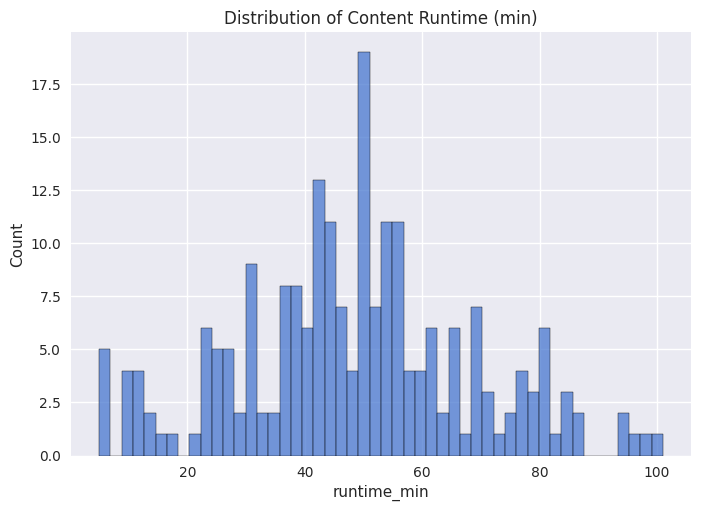

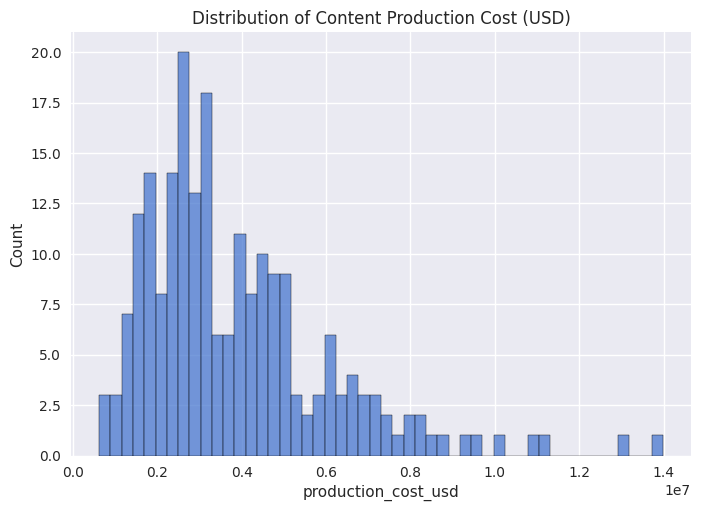

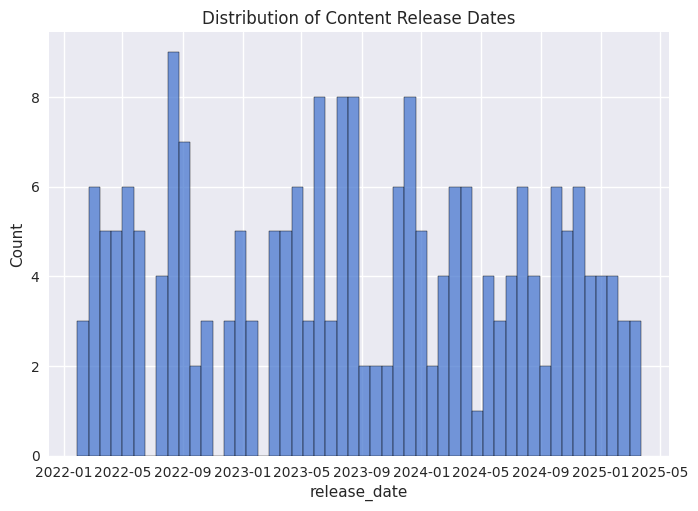

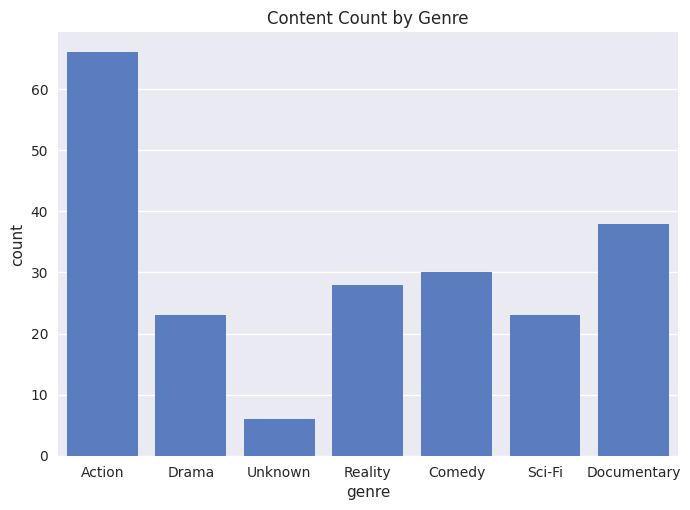

In [14]:
print("\nSample values:")
print(con.execute(""" SELECT * FROM content_clean LIMIT 5; """).fetch_df())

print("\nContent Raw Table Info:")
print(con.execute("""SELECT * FROM content_clean""").fetch_df().info())

print ("\nGenre values:")
print(con.execute("SELECT genre, COUNT(genre) from content_clean GROUP BY genre").fetchdf())

print("\nDescriptive Statistics for Quantitative Columns:")
print(con.execute("SELECT runtime_min, release_date FROM content_clean").fetchdf().describe())

print("\nDuplicate Count:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT content_id) AS distinct_content_ids
FROM content_clean;
""").fetchdf())

sns.histplot(con.execute("SELECT runtime_min FROM content_clean").fetch_df(), x='runtime_min', bins=50)
plt.title('Distribution of Content Runtime (min)')
plt.show()

sns.histplot(con.execute("SELECT production_cost_usd FROM content_clean").fetch_df(), x='production_cost_usd', bins=50)
plt.title('Distribution of Content Production Cost (USD)')
plt.show()

sns.histplot(con.execute("SELECT release_date FROM content_clean").fetch_df(), x='release_date', bins=50)
plt.title('Distribution of Content Release Dates')
plt.show()

sns.countplot(data=con.execute("SELECT * FROM content_clean").fetch_df(), x='genre', order=con.execute("SELECT genre, COUNT(genre) from content_clean GROUP BY genre").fetch_df()['genre'])
plt.title('Content Count by Genre')
plt.show()

content = con.execute("""SELECT * FROM content_clean""").fetch_df()

Handle missing watch_completion_pct in sessions

In [15]:
# 1) Keep a 1-row-per-content lookup of runtimes
runtime_lookup = (
    content[['content_id', 'runtime_min']]
    .drop_duplicates('content_id')
    .set_index('content_id')
)

# 2) Attach runtime to sessions (left join on content_id)
sessions = sessions.join(runtime_lookup, on='content_id', how='left')

# 3) Build a mask of rows that need filling
needs_fill = sessions['watch_completion_pct'].isna()

# 4) Avoid divide-by-zero or missing runtime
valid_runtime = sessions['runtime_min'] > 0

# 5) Compute completion % = (watched / total) * 100, clamp to [0, 100]
calc_pct = (
    (sessions['duration_min'] / sessions['runtime_min']) * 100
).clip(lower=0, upper=100)

# 6) Only fill where missing AND runtime is valid AND duration is not null
fill_mask = needs_fill & valid_runtime & sessions['duration_min'].notna()

sessions.loc[fill_mask, 'watch_completion_pct'] = calc_pct.loc[fill_mask]

# (Optional) If you don’t want to keep the joined column:
sessions = sessions.drop(columns=['runtime_min'])
# sessions = sessions.dropna(subset=['watch_completion_pct'])

sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44547 entries, 0 to 44546
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session_id            44547 non-null  object        
 1   date                  44547 non-null  datetime64[us]
 2   duration_min          44547 non-null  float64       
 3   watch_completion_pct  44332 non-null  float64       
 4   device                44077 non-null  object        
 5   content_type          44547 non-null  object        
 6   user_id               44547 non-null  object        
 7   content_id            44547 non-null  object        
dtypes: datetime64[us](1), float64(2), object(5)
memory usage: 2.7+ MB


## EDA

### Stakeholder Questions:
1. What are the overall trends in engagement/activity during this time period? How do they vary by different segments?
2. Are we keeping the users we acquire, and what segments have the best/worst retention?
3. How has our user base been growing?
4. What content is performing best/worst?


### Metrics

| KPI                                       | Formula / Logic                               | Why it matters                    |
| ----------------------------------------- | --------------------------------------------- | --------------------------------- |
| **Daily/Monthly Active Users**            | Count distinct users per day/month            | Tracks engagement & activity      |
| **Engagement Rate**                       | Sessions per active user per day              | How “sticky” product is           |
| **Average Watch Time / Session Duration** | Avg(duration_min)                             | Content/Session quality           |
| **Content Completion Rate**               | Avg(watch_completion_pct)                     | Indicates quality & engagement    |
| **Retention Rate**                        | (Returning users at t+30 / users active at t) | User loyalty                      |
| **Churn Rate**                            | 1 – retention                                 | Attrition analysis                |
| **Subscriber Growth Rate**                | (New subs – churned subs) / prior subs        | Measures platform growth          |

In [16]:
# Merge Data
df = sessions.merge(
    users,
    on='user_id',
    how='left',
    suffixes=('_session', '_user')
).merge(
    content,
    on='content_id',
    how='left',
    suffixes=('', '_content')
)
df = df.rename(columns={'duration_min': 'watch_duration_min', 'runtime_min' : 'content_runtime_min', 'price_ucsd' : 'plan_price_usd', 'device': 'session_device', 'content_type': 'session_content_type'})

df.head()

,session_id,date,watch_duration_min,watch_completion_pct,session_device,session_content_type,user_id,content_id,signup_date,cancel_date,region,plan_type,price_usd,acquisition_channel,genre,content_runtime_min,release_date,production_cost_usd,licensed_flag
0,S0036147,2023-02-02,54.81,1.3,Tablet,Movie,U01854,C0098,2023-05-01,NaT,APAC,Premium,16.99,Paid Search,Action,80.0,2022-07-18,3969867.19,1.0
1,S0036173,2024-04-14,45.36,27.4,Mobile,Movie,U00382,C0150,2023-11-10,NaT,LATAM,Basic,8.99,Paid Social,Sci-Fi,49.0,2025-03-14,2935658.89,1.0
2,S0036261,2023-06-28,97.77,76.3,Mobile,Movie,U01785,C0119,2024-03-24,NaT,North America,Standard,13.99,Referral,Drama,5.0,2022-08-02,3222188.37,1.0
3,S0036301,2024-06-12,10.33,71.2,TV,Movie,U01740,C0217,2023-11-18,NaT,North America,Premium,18.99,Organic,Sci-Fi,49.0,2025-03-24,2461490.46,1.0
4,S0036323,2024-03-23,1.64,2.9,TV,Movie,U00566,C0139,2023-03-26,NaT,LATAM,Standard,11.99,Referral,Comedy,51.0,2024-08-28,5597250.83,1.0


### 1) What are the overall trends in engagement/activity during this time period? How do they vary by different segments?

#### User Activity

Index(['session_id', 'date', 'watch_duration_min', 'watch_completion_pct',
       'session_device', 'session_content_type', 'user_id', 'content_id',
       'signup_date', 'cancel_date', 'region', 'plan_type', 'price_usd',
       'acquisition_channel', 'genre', 'content_runtime_min', 'release_date',
       'production_cost_usd', 'licensed_flag'],
      dtype='object')


/tmp/ipykernel_1812/1136382685.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='date', freq='M'))['user_id']


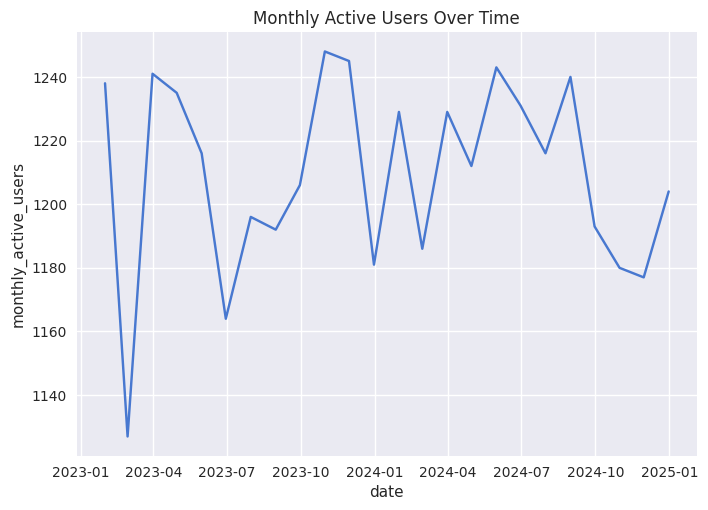

/tmp/ipykernel_1812/1136382685.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='date', freq='M'))['user_id']


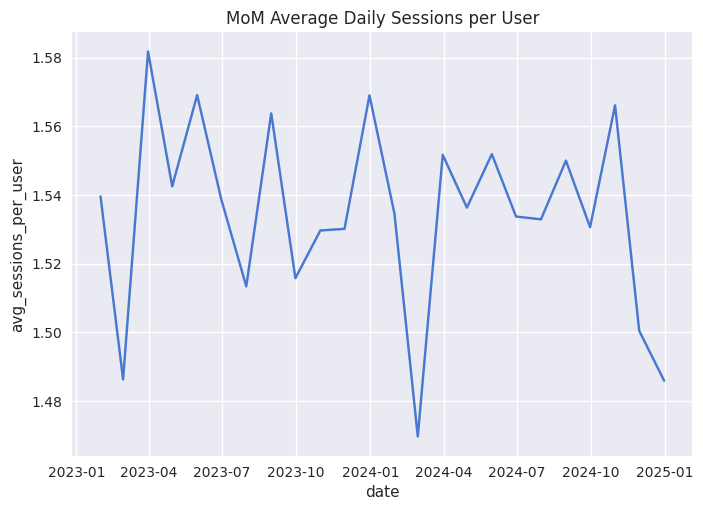

/tmp/ipykernel_1812/1136382685.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='date', freq='M'))['watch_duration_min']


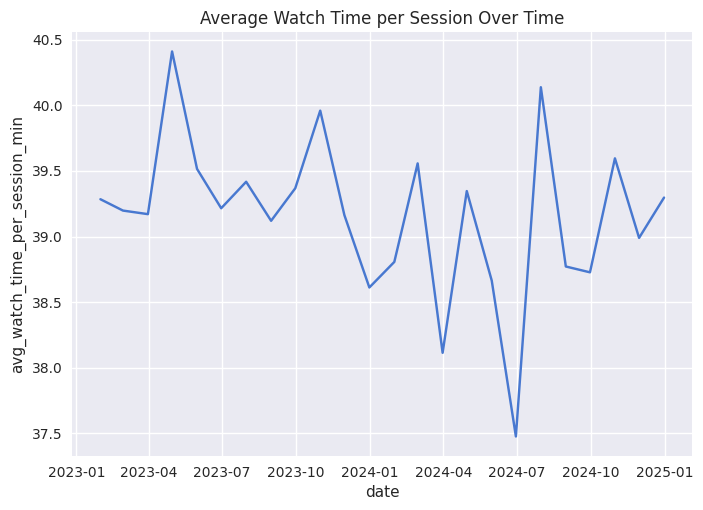

/tmp/ipykernel_1812/1136382685.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='date', freq='M'), 'user_id'])['watch_duration_min']


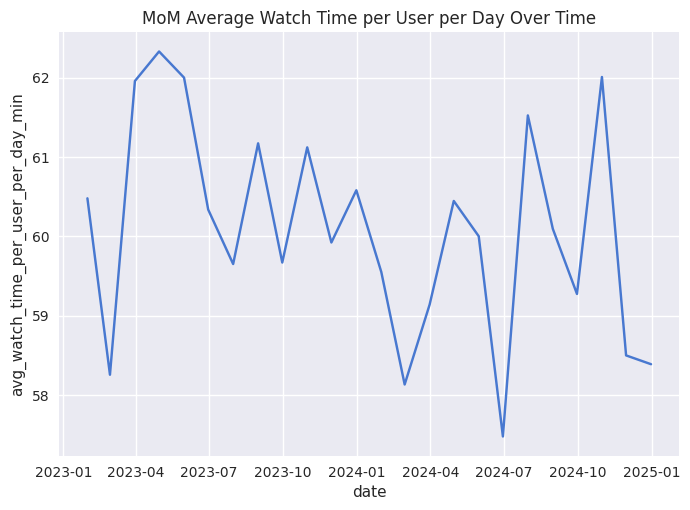

/tmp/ipykernel_1812/1136382685.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='date', freq='M'))['watch_completion_pct']


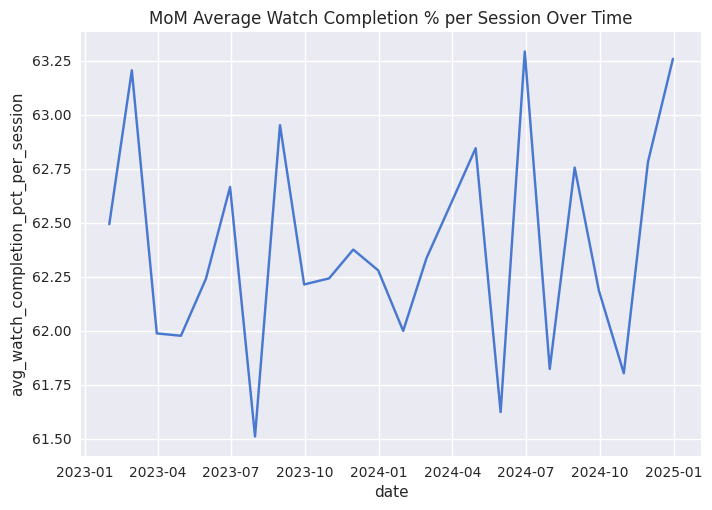

In [17]:
print(df.columns)

# MAU

monthly_active_users = (
    df.groupby(pd.Grouper(key='date', freq='M'))['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)
sns.lineplot(data=monthly_active_users, x='date', y='monthly_active_users')
plt.title('Monthly Active Users Over Time')
plt.show()

# Sessions Per User

MoM_sessions_per_user = (
    df.groupby(pd.Grouper(key='date', freq='M'))['user_id']
    .value_counts()
    .reset_index(name='sessions_count')
)

MoM_avg_sessions_per_user = (
    MoM_sessions_per_user.groupby('date')['sessions_count']
    .mean()
    .reset_index(name='avg_sessions_per_user')
)

sns.lineplot(data=MoM_avg_sessions_per_user, x='date', y='avg_sessions_per_user')
plt.title('MoM Average Daily Sessions per User')
plt.show()

# MoM Average Watch time per Session

MoM_avg_watch_time_per_session = (
    df.groupby(pd.Grouper(key='date', freq='M'))['watch_duration_min']
    .mean()
    .reset_index(name='avg_watch_time_per_session_min')
)

sns.lineplot(data=MoM_avg_watch_time_per_session, x='date', y='avg_watch_time_per_session_min')
plt.title('Average Watch Time per Session Over Time')
plt.show()

# MoM Average Watch time per User per day
MoM_avg_watch_time_per_user_per_day = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'user_id'])['watch_duration_min']
    .sum()
    .reset_index()
    .groupby('date')['watch_duration_min']
    .mean()
    .reset_index(name='avg_watch_time_per_user_per_day_min')
)
sns.lineplot(data=MoM_avg_watch_time_per_user_per_day, x='date', y='avg_watch_time_per_user_per_day_min')
plt.title('MoM Average Watch Time per User per Day Over Time')
plt.show()

# MoM Average Watch Completion % per Session
MoM_avg_watch_completion_per_session = (
    df.groupby(pd.Grouper(key='date', freq='M'))['watch_completion_pct']
    .mean()
    .reset_index(name='avg_watch_completion_pct_per_session')
)
sns.lineplot(data=MoM_avg_watch_completion_per_session, x='date', y='avg_watch_completion_pct_per_session')
plt.title('MoM Average Watch Completion % per Session Over Time')
plt.show()

### Subscriber growth, retention, and churn

#### Segmentation

/tmp/ipykernel_1812/3498874279.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='date', freq='M'), 'region'])['user_id']


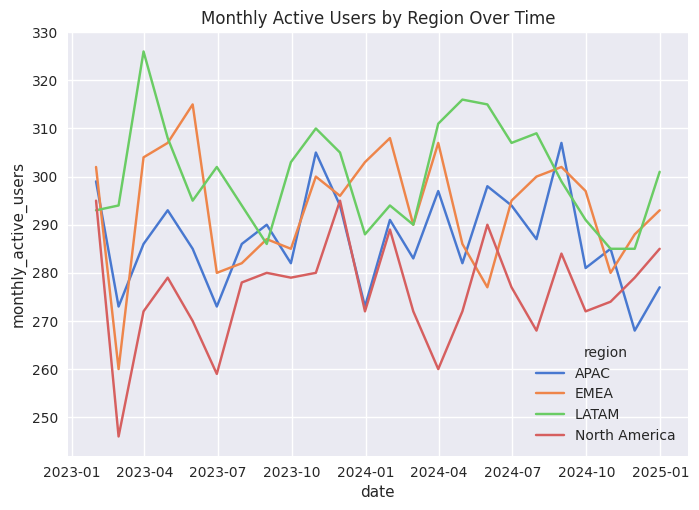

/tmp/ipykernel_1812/3498874279.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='date', freq='M'), 'plan_type'])['user_id']


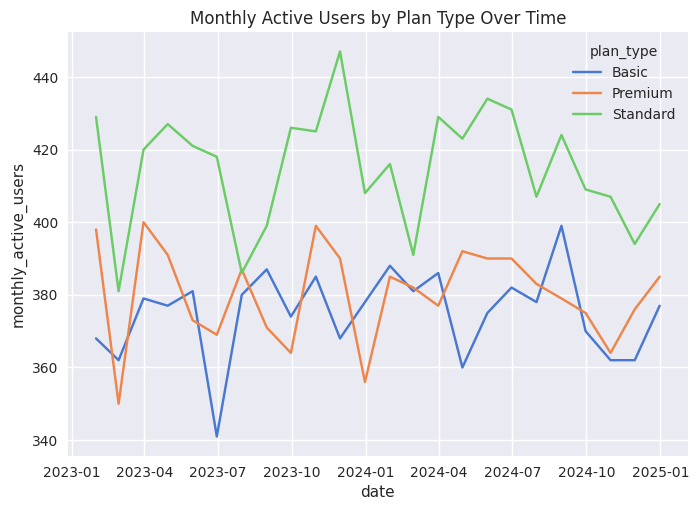

In [18]:
# Segmentation By Region and Plan Type
monthly_active_users_by_region = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'region'])['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)
monthly_active_users_by_region = monthly_active_users_by_region[monthly_active_users_by_region['region'] != 'Unknown']

sns.lineplot(data=monthly_active_users_by_region, x='date', y='monthly_active_users', hue='region')
plt.title('Monthly Active Users by Region Over Time')
plt.show()

monthly_active_users_by_plan = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'plan_type'])['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)

monthly_active_users_by_plan = monthly_active_users_by_plan[monthly_active_users_by_plan['plan_type'] != 'Unknown']

sns.lineplot(data=monthly_active_users_by_plan, x='date', y='monthly_active_users', hue='plan_type')
plt.title('Monthly Active Users by Plan Type Over Time')
plt.show()